In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc

adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans\Hao_Harmony_test_no_scale.h5ad")
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,17,16
CD4_T,1719,813
CD8_T,7,5
DC,1250,579
Mono,73,65
NK,232,127
other,380,205
other_T,1097,568


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [9]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\LR_classifiers")

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_Harmony_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
[0.9993076351384425, 0.9976011024469598, 0.9942753623188405, 0.9959317088520805, 0.9999536977676918, 0.9995837533741915, 0.9955572263309851]
K-fold CV for: CD4_T


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[0.9898803380873631, 0.97934509183607, 0.9809516894132482, 0.9800956343587763, 0.9988506931898795, 0.9963718443101728, 0.973358643397179]
K-fold CV for: CD8_T
[0.9693937024309267, 0.9306877025418441, 0.8703920043608205, 0.8995042561999769, 0.9859148784851787, 0.9525574791662683, 0.8821823485218792]
K-fold CV for: DC
[0.9983679918846509, 0.9667090647073067, 0.9595964305000331, 0.9630864532686786, 0.9998605369000144, 0.9946317228165522, 0.962286696876452]
K-fold CV for: Mono
[0.9935894262653358, 0.9843363461230912, 0.9946745562130177, 0.9894755563277122, 0.9987057734512303, 0.9952069147265294, 0.9848975536564113]
K-fold CV for: NK
[0.9979043529245557, 0.9917928691705905, 0.9900341785224851, 0.9909110467662025, 0.9998185287684492, 0.9985422718032421, 0.9897282667639073]
K-fold CV for: other
[0.9942199787898597, 0.9419520144549349, 0.7756763256489013, 0.8494567878675205, 0.9573514637620926, 0.8742015446558051, 0.8513668561060449]
K-fold CV for: other_T


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[0.9901832223604211, 0.9020868928907744, 0.8593275689356341, 0.880127433035868, 0.9935611519512146, 0.9368945913388902, 0.8753262254183193]


In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999308,0.997601,0.994275,0.995932,0.999954,0.999584,0.995557
CD4_T,0.989880,0.979345,0.980952,0.980096,0.998851,0.996372,0.973359
CD8_T,0.969394,0.930688,0.870392,0.899504,0.985915,0.952557,0.882182
DC,0.998368,0.966709,0.959596,0.963086,0.999861,0.994632,0.962287
Mono,0.993589,0.984336,0.994675,0.989476,0.998706,0.995207,0.984898
NK,0.997904,0.991793,0.990034,0.990911,0.999819,0.998542,0.989728
other,0.994220,0.941952,0.775676,0.849457,0.957351,0.874202,0.851367
other_T,0.990183,0.902087,0.859328,0.880127,0.993561,0.936895,0.875326


In [11]:
os.getcwd()

'C:\\Users\\evanlee\\Documents\\GitHub\\EvanPys\\Progress\\PBMC_Hao_ztrans_v2\\Level1\\LR_classifiers'

In [12]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L1.csv')

## Read saved .pkl

## Plot classifier K-fold CV metrics

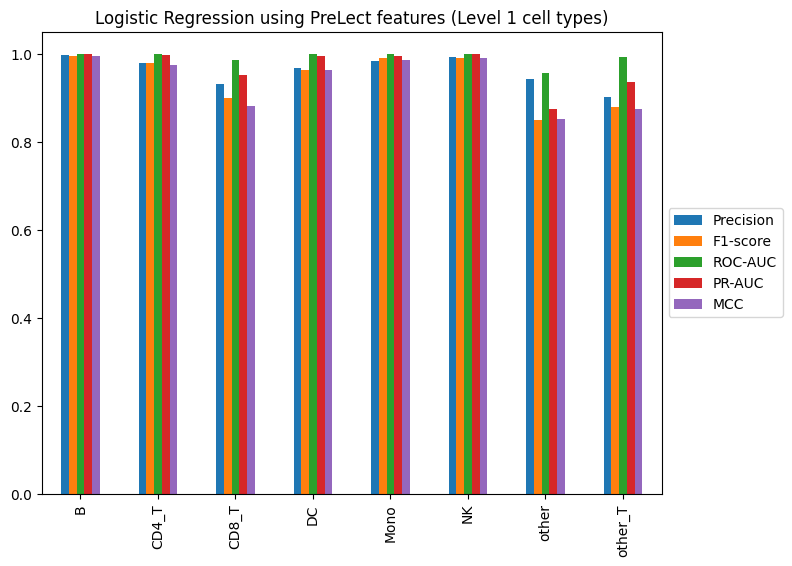

In [13]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(8,6), title='Logistic Regression using PreLect features (Level 1 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))